In [3]:
# ============================================================================
# 1. IMPORT LIBRARIES
# ============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Models
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

# MLflow
import mlflow
import mlflow.sklearn
from mlflow.models.signature import infer_signature

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [4]:
# ============================================================================
# 2. LOAD DATA
# ============================================================================

# Load the dataset

df = pd.read_csv('/content/Medicalpremium.csv')

print("Dataset loaded successfully!")
print(f"Dataset Shape: {df.shape}")
print("\nFirst few rows:")
print(df.head())


Dataset loaded successfully!
Dataset Shape: (986, 11)

First few rows:
   Age  Diabetes  BloodPressureProblems  AnyTransplants  AnyChronicDiseases  \
0   45         0                      0               0                   0   
1   60         1                      0               0                   0   
2   36         1                      1               0                   0   
3   52         1                      1               0                   1   
4   38         0                      0               0                   1   

   Height  Weight  KnownAllergies  HistoryOfCancerInFamily  \
0     155      57               0                        0   
1     180      73               0                        0   
2     158      59               0                        0   
3     183      93               0                        0   
4     166      88               0                        0   

   NumberOfMajorSurgeries  PremiumPrice  
0                       0         25000

In [5]:
# ============================================================================
# 3. EXPLORATORY DATA ANALYSIS (EDA)
# ============================================================================

print("\n" + "="*80)
print("EXPLORATORY DATA ANALYSIS")
print("="*80)

# 3.1 Basic Information
print("\n--- Dataset Info ---")
print(df.info())

print("\n--- Statistical Summary ---")
print(df.describe())

print("\n--- Missing Values ---")
print(df.isnull().sum())

print("\n--- Data Types ---")
print(df.dtypes)

print("\n--- Unique Values in Each Column ---")
for col in df.columns:
    print(f"{col}: {df[col].nunique()} unique values")

# 3.2 Target Variable Analysis
print("\n--- Target Variable (PremiumPrice) Statistics ---")
print(f"Mean: {df['PremiumPrice'].mean():.2f}")
print(f"Median: {df['PremiumPrice'].median():.2f}")
print(f"Std Dev: {df['PremiumPrice'].std():.2f}")
print(f"Min: {df['PremiumPrice'].min():.2f}")
print(f"Max: {df['PremiumPrice'].max():.2f}")


EXPLORATORY DATA ANALYSIS

--- Dataset Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 986 entries, 0 to 985
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   Age                      986 non-null    int64
 1   Diabetes                 986 non-null    int64
 2   BloodPressureProblems    986 non-null    int64
 3   AnyTransplants           986 non-null    int64
 4   AnyChronicDiseases       986 non-null    int64
 5   Height                   986 non-null    int64
 6   Weight                   986 non-null    int64
 7   KnownAllergies           986 non-null    int64
 8   HistoryOfCancerInFamily  986 non-null    int64
 9   NumberOfMajorSurgeries   986 non-null    int64
 10  PremiumPrice             986 non-null    int64
dtypes: int64(11)
memory usage: 84.9 KB
None

--- Statistical Summary ---
              Age    Diabetes  BloodPressureProblems  AnyTransplants  \
count  986.000000  986.0


DATA VISUALIZATIONS


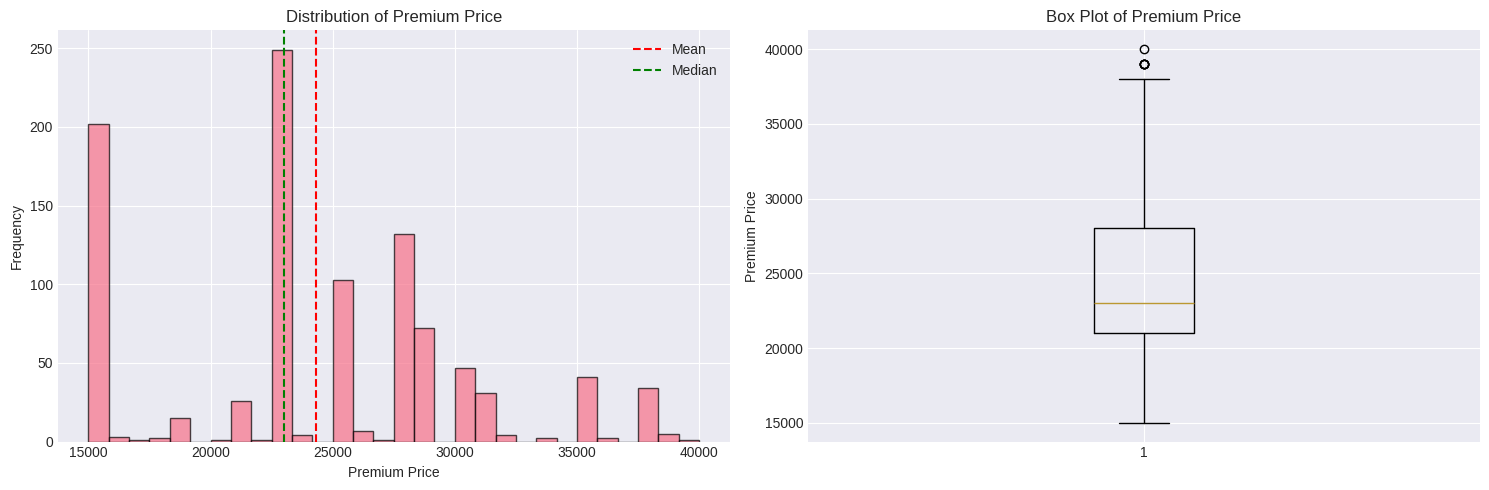

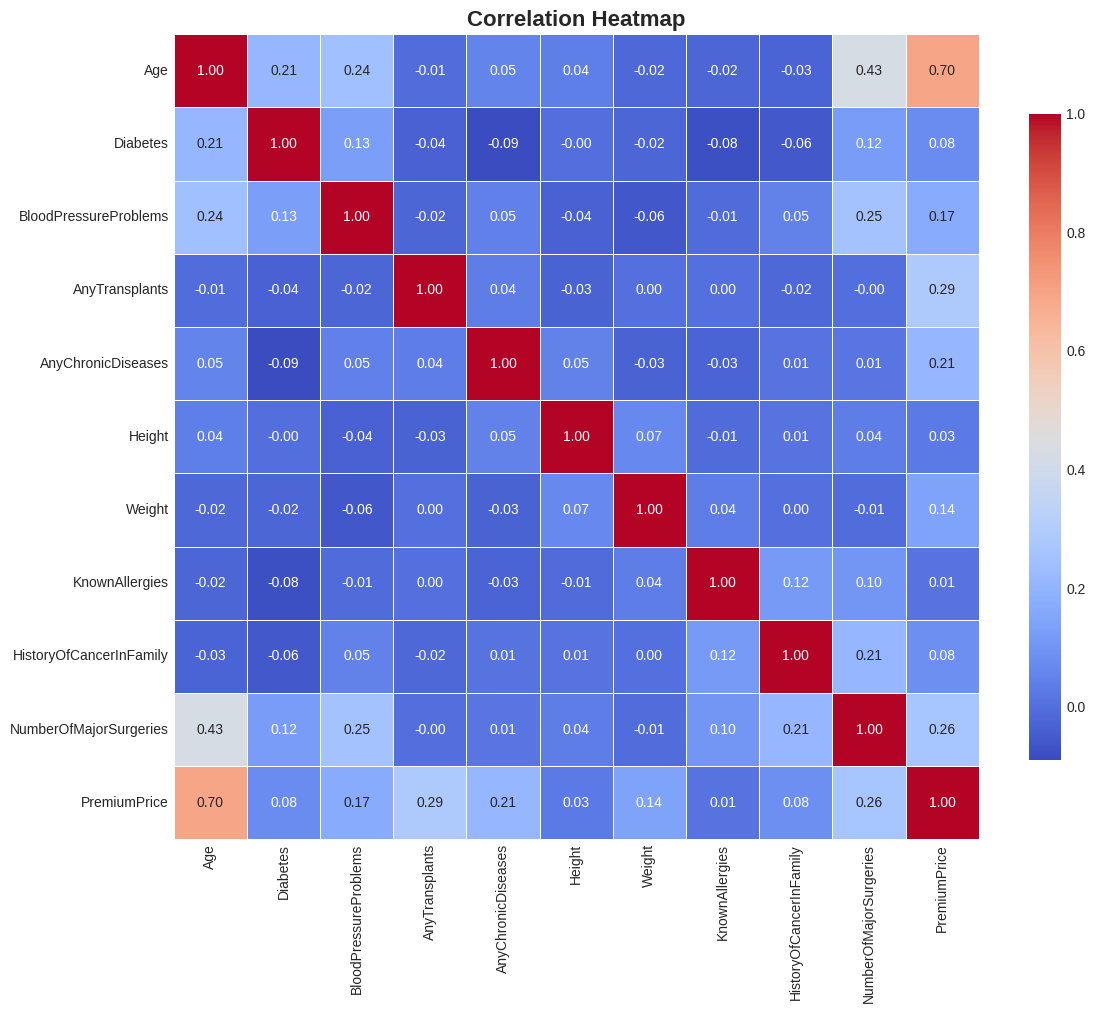


--- Correlation with Premium Price ---
PremiumPrice               1.000000
Age                        0.697540
AnyTransplants             0.289056
NumberOfMajorSurgeries     0.264250
AnyChronicDiseases         0.208610
BloodPressureProblems      0.167097
Weight                     0.141507
HistoryOfCancerInFamily    0.083139
Diabetes                   0.076209
Height                     0.026910
KnownAllergies             0.012103
Name: PremiumPrice, dtype: float64


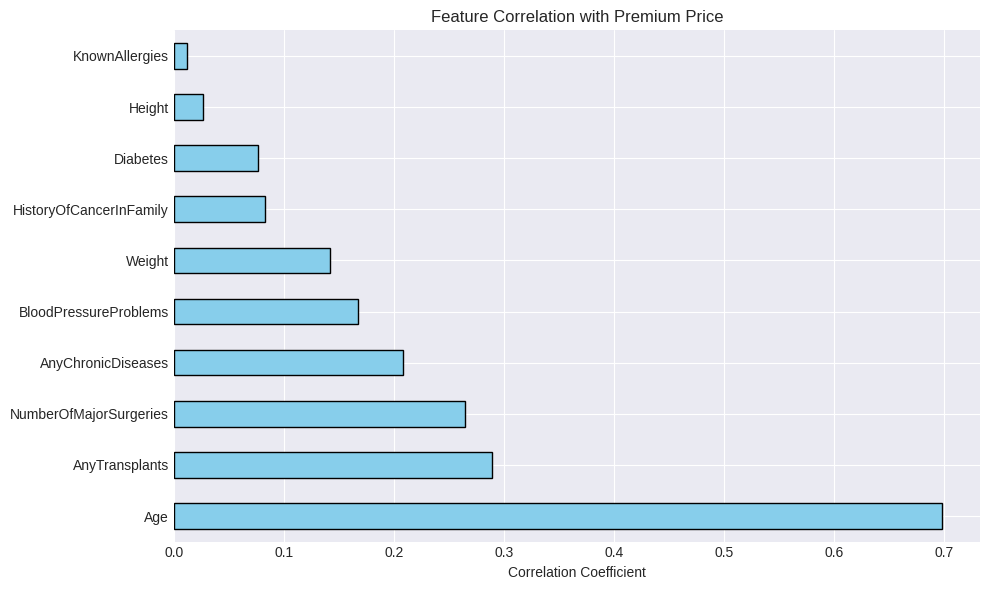

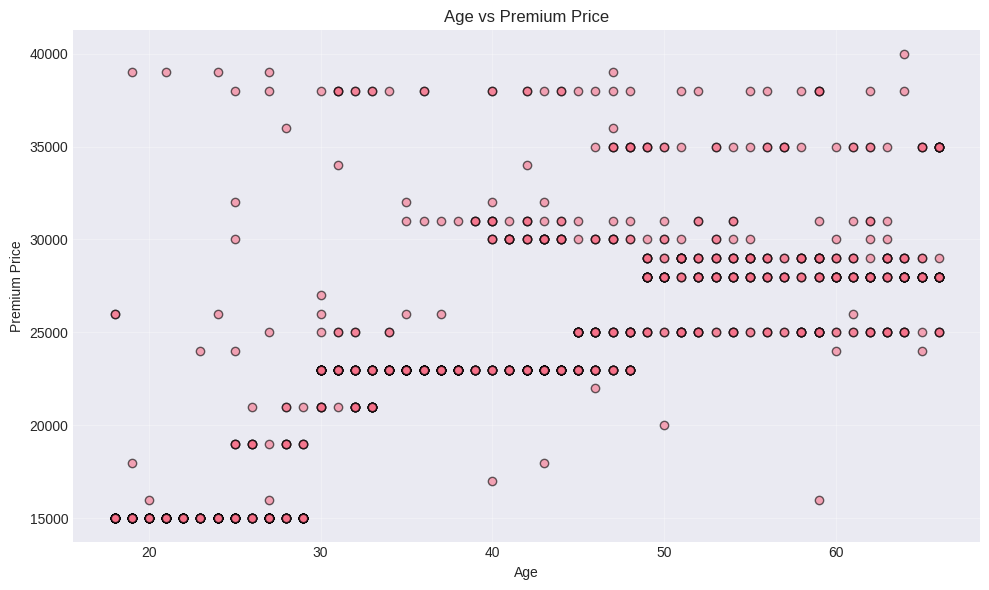

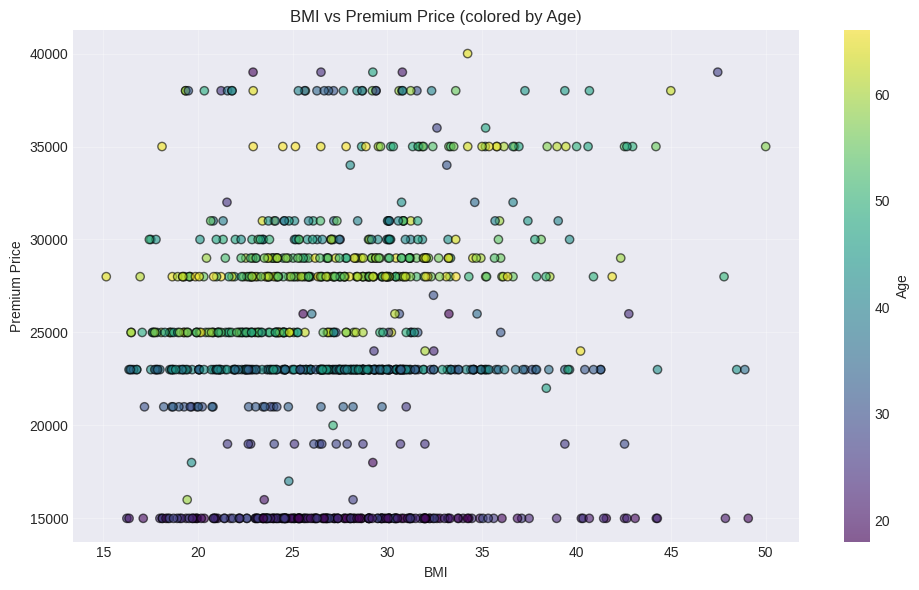

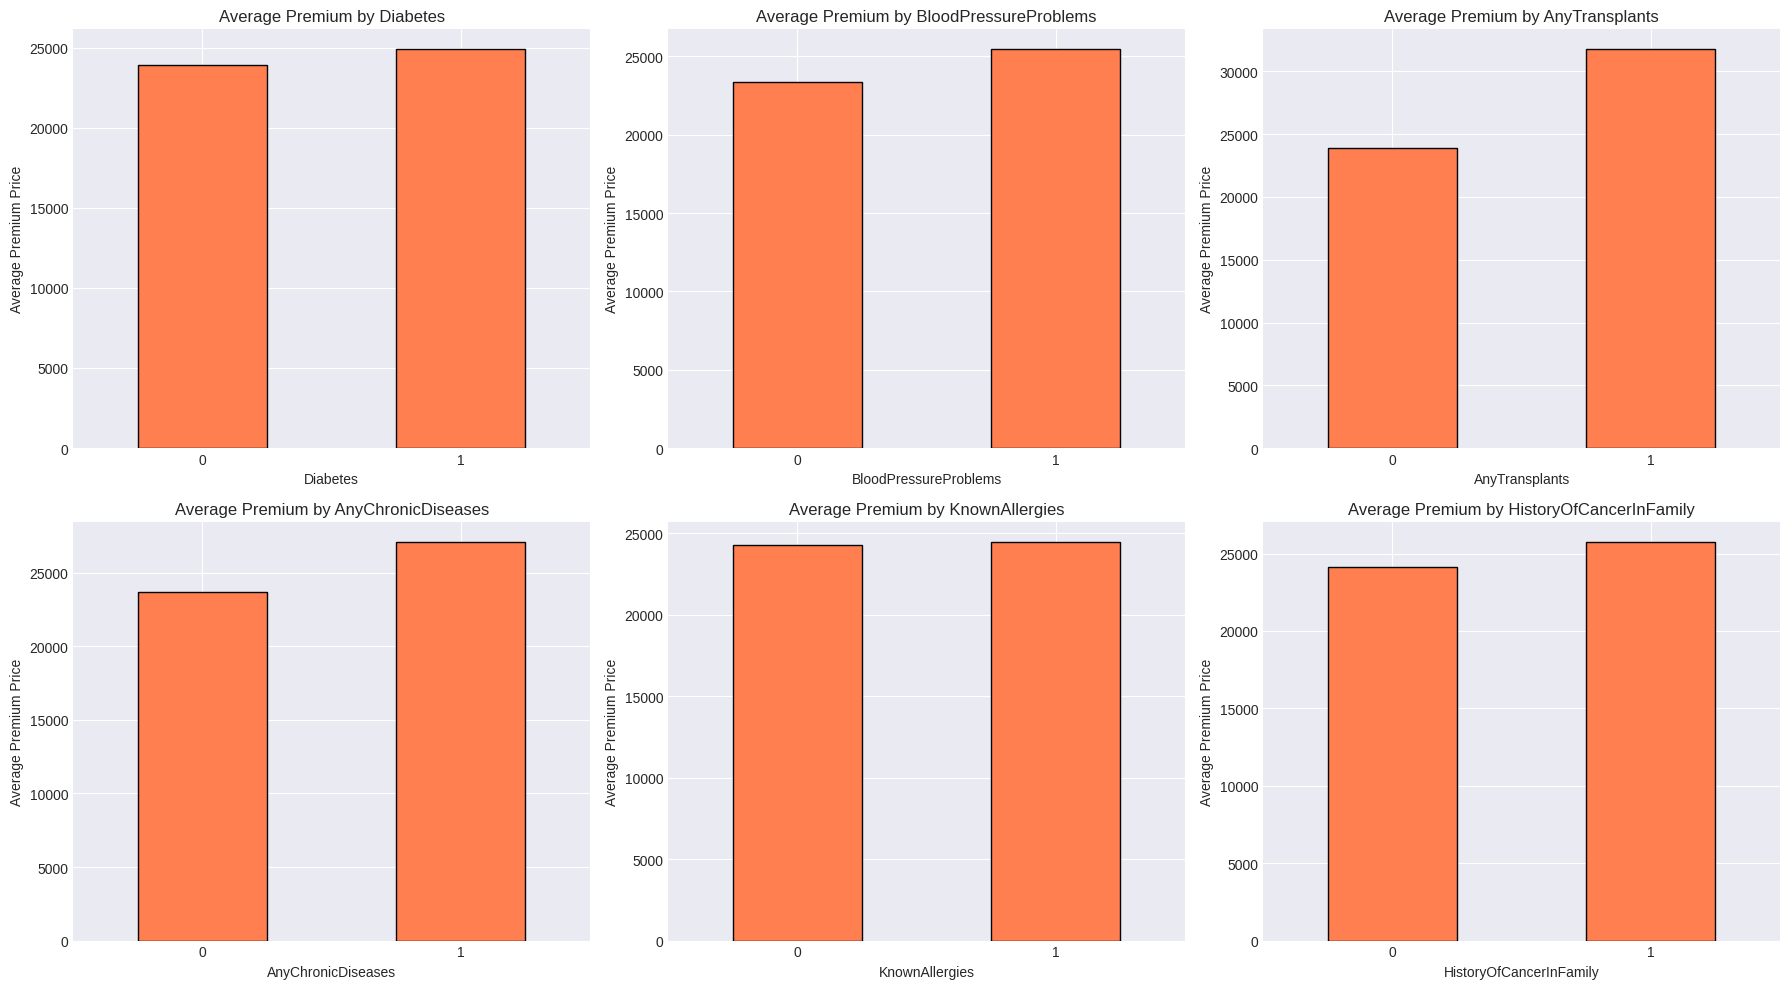

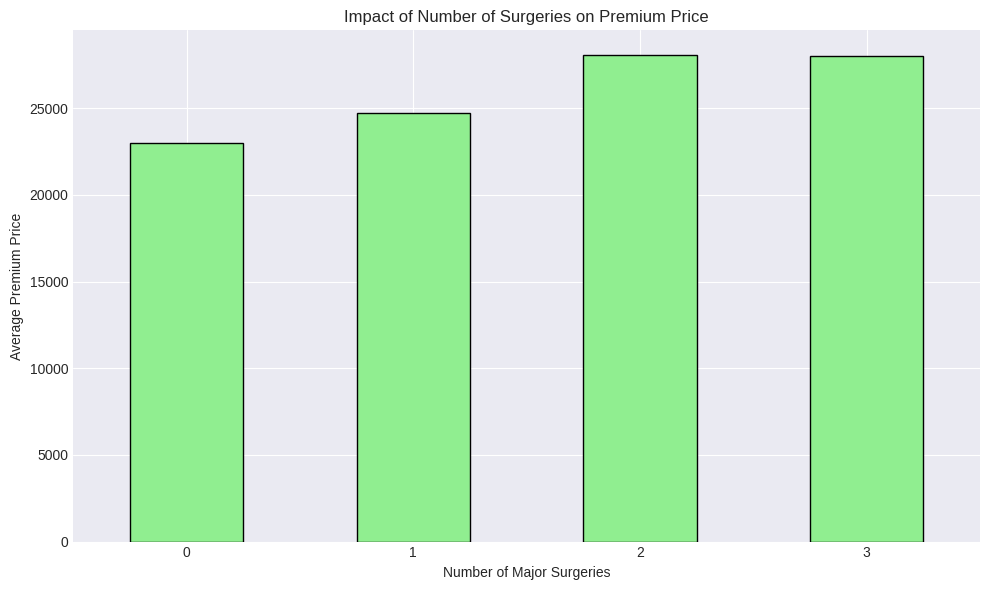

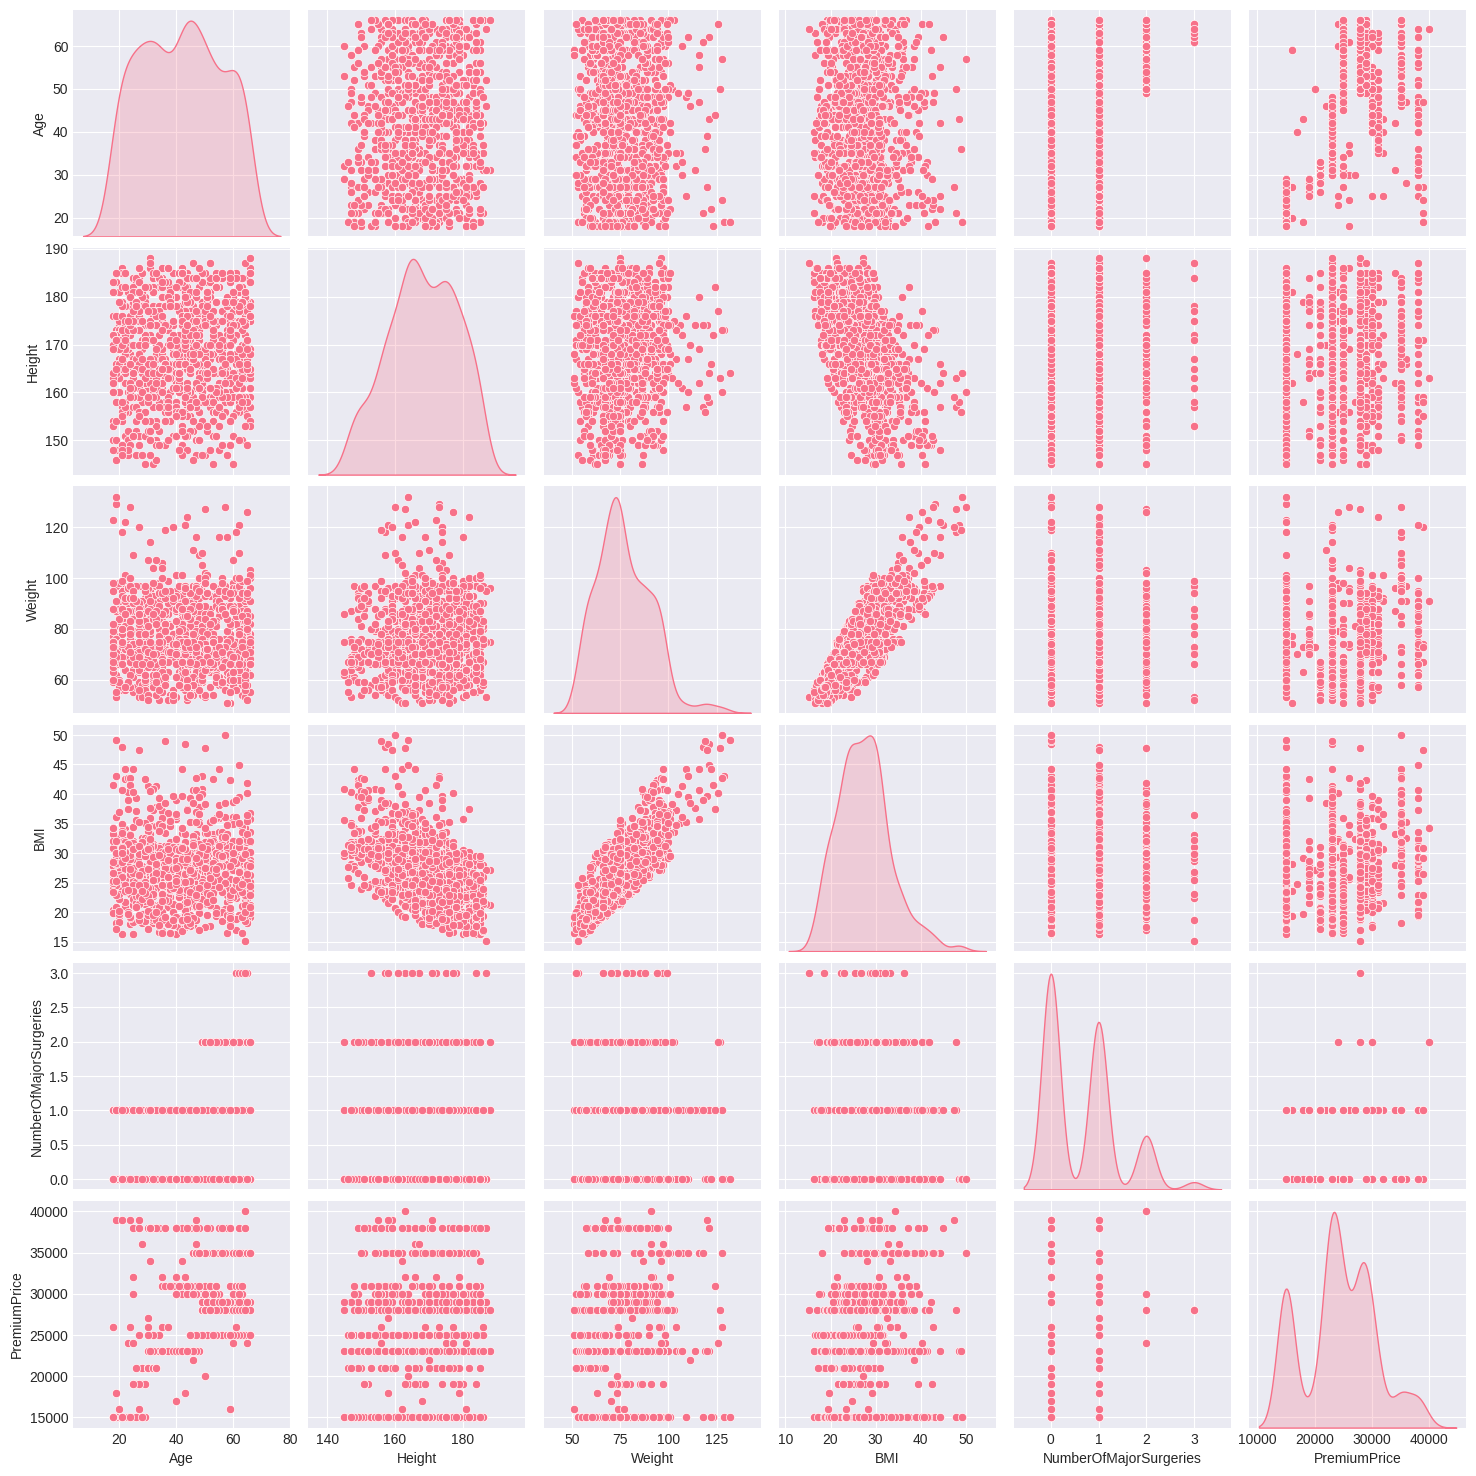

In [6]:
# ============================================================================
# 4. VISUALIZATIONS
# ============================================================================

print("\n" + "="*80)
print("DATA VISUALIZATIONS")
print("="*80)

# 4.1 Distribution of Target Variable
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].hist(df['PremiumPrice'], bins=30, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Premium Price')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Premium Price')
axes[0].axvline(df['PremiumPrice'].mean(), color='red', linestyle='--', label='Mean')
axes[0].axvline(df['PremiumPrice'].median(), color='green', linestyle='--', label='Median')
axes[0].legend()

axes[1].boxplot(df['PremiumPrice'])
axes[1].set_ylabel('Premium Price')
axes[1].set_title('Box Plot of Premium Price')

plt.tight_layout()
plt.savefig('01_target_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# 4.2 Correlation Heatmap
plt.figure(figsize=(12, 10))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm',
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Correlation Heatmap', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('02_correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

# 4.3 Feature Correlations with Target
correlations = df.corr()['PremiumPrice'].sort_values(ascending=False)
print("\n--- Correlation with Premium Price ---")
print(correlations)

plt.figure(figsize=(10, 6))
correlations[1:].plot(kind='barh', color='skyblue', edgecolor='black')
plt.xlabel('Correlation Coefficient')
plt.title('Feature Correlation with Premium Price')
plt.tight_layout()
plt.savefig('03_feature_correlations.png', dpi=300, bbox_inches='tight')
plt.show()

# 4.4 Age vs Premium Price
plt.figure(figsize=(10, 6))
plt.scatter(df['Age'], df['PremiumPrice'], alpha=0.6, edgecolors='black')
plt.xlabel('Age')
plt.ylabel('Premium Price')
plt.title('Age vs Premium Price')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('04_age_vs_premium.png', dpi=300, bbox_inches='tight')
plt.show()

# 4.5 BMI Analysis
df['BMI'] = df['Weight'] / ((df['Height']/100) ** 2)
plt.figure(figsize=(10, 6))
plt.scatter(df['BMI'], df['PremiumPrice'], alpha=0.6, c=df['Age'], cmap='viridis', edgecolors='black')
plt.colorbar(label='Age')
plt.xlabel('BMI')
plt.ylabel('Premium Price')
plt.title('BMI vs Premium Price (colored by Age)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('05_bmi_vs_premium.png', dpi=300, bbox_inches='tight')
plt.show()

# 4.6 Categorical Features Distribution
categorical_features = ['Diabetes', 'BloodPressureProblems', 'AnyTransplants',
                        'AnyChronicDiseases', 'KnownAllergies', 'HistoryOfCancerInFamily']

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

for idx, feature in enumerate(categorical_features):
    df.groupby(feature)['PremiumPrice'].mean().plot(kind='bar', ax=axes[idx], color='coral', edgecolor='black')
    axes[idx].set_title(f'Average Premium by {feature}')
    axes[idx].set_xlabel(feature)
    axes[idx].set_ylabel('Average Premium Price')
    axes[idx].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.savefig('06_categorical_features.png', dpi=300, bbox_inches='tight')
plt.show()

# 4.7 Number of Major Surgeries Impact
plt.figure(figsize=(10, 6))
df.groupby('NumberOfMajorSurgeries')['PremiumPrice'].mean().plot(kind='bar', color='lightgreen', edgecolor='black')
plt.xlabel('Number of Major Surgeries')
plt.ylabel('Average Premium Price')
plt.title('Impact of Number of Surgeries on Premium Price')
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig('07_surgeries_impact.png', dpi=300, bbox_inches='tight')
plt.show()

# 4.8 Pairplot for Key Features
key_features = ['Age', 'Height', 'Weight', 'BMI', 'NumberOfMajorSurgeries', 'PremiumPrice']
sns.pairplot(df[key_features], height=2.5, diag_kind='kde')
plt.savefig('08_pairplot.png', dpi=300, bbox_inches='tight')
plt.show()

In [7]:
# ============================================================================
# 5. FEATURE ENGINEERING & PREPROCESSING
# ============================================================================

print("\n" + "="*80)
print("FEATURE ENGINEERING & PREPROCESSING")
print("="*80)

# Create a copy for preprocessing
df_processed = df.copy()

# 5.1 Create Additional Features
df_processed['BMI'] = df_processed['Weight'] / ((df_processed['Height']/100) ** 2)
df_processed['Age_BMI_Interaction'] = df_processed['Age'] * df_processed['BMI']
df_processed['Health_Risk_Score'] = (
    df_processed['Diabetes'] +
    df_processed['BloodPressureProblems'] +
    df_processed['AnyChronicDiseases'] +
    df_processed['NumberOfMajorSurgeries']
)
df_processed['Age_Group'] = pd.cut(df_processed['Age'], bins=[0, 25, 40, 60, 100], labels=[0, 1, 2, 3])
df_processed['Age_Group'] = df_processed['Age_Group'].astype(int)

print("New features created:")
print("- BMI")
print("- Age_BMI_Interaction")
print("- Health_Risk_Score")
print("- Age_Group")

# 5.2 Check for outliers using IQR method
print("\n--- Outlier Detection ---")
numerical_cols = ['Age', 'Height', 'Weight', 'BMI', 'PremiumPrice']

for col in numerical_cols:
    Q1 = df_processed[col].quantile(0.25)
    Q3 = df_processed[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df_processed[(df_processed[col] < lower_bound) | (df_processed[col] > upper_bound)]
    print(f"{col}: {len(outliers)} outliers detected")

# 5.3 Prepare features and target
X = df_processed.drop('PremiumPrice', axis=1)
y = df_processed['PremiumPrice']

print(f"\nFeature Matrix Shape: {X.shape}")
print(f"Target Vector Shape: {y.shape}")
print(f"\nFeatures: {list(X.columns)}")

# 5.4 Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\nTraining set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

# 5.5 Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



FEATURE ENGINEERING & PREPROCESSING
New features created:
- BMI
- Age_BMI_Interaction
- Health_Risk_Score
- Age_Group

--- Outlier Detection ---
Age: 0 outliers detected
Height: 0 outliers detected
Weight: 16 outliers detected
BMI: 22 outliers detected
PremiumPrice: 6 outliers detected

Feature Matrix Shape: (986, 14)
Target Vector Shape: (986,)

Features: ['Age', 'Diabetes', 'BloodPressureProblems', 'AnyTransplants', 'AnyChronicDiseases', 'Height', 'Weight', 'KnownAllergies', 'HistoryOfCancerInFamily', 'NumberOfMajorSurgeries', 'BMI', 'Age_BMI_Interaction', 'Health_Risk_Score', 'Age_Group']

Training set size: 788
Test set size: 198


In [8]:
# ============================================================================
# 6. MODEL BUILDING WITH MLFLOW TRACKING
# ============================================================================

print("\n" + "="*80)
print("MODEL BUILDING WITH MLFLOW TRACKING")
print("="*80)

# Set MLflow experiment
mlflow.set_experiment("Medical_Premium_Prediction")

# Function to evaluate model
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    """Train and evaluate model with metrics"""
    model.fit(X_train, y_train)

    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Metrics
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    # Cross-validation score
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
    cv_mean = cv_scores.mean()
    cv_std = cv_scores.std()

    results = {
        'Model': model_name,
        'Train_RMSE': train_rmse,
        'Test_RMSE': test_rmse,
        'Train_MAE': train_mae,
        'Test_MAE': test_mae,
        'Train_R2': train_r2,
        'Test_R2': test_r2,
        'CV_R2_Mean': cv_mean,
        'CV_R2_Std': cv_std
    }

    return results, model

# Store results
all_results = []

# 6.1 Baseline Models
print("\n--- Training Baseline Models ---")

baseline_models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(random_state=42),
    'Lasso Regression': Lasso(random_state=42),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42, n_jobs=-1)
}

for name, model in baseline_models.items():
    with mlflow.start_run(run_name=name):
        print(f"\nTraining {name}...")
        results, trained_model = evaluate_model(model, X_train_scaled, X_test_scaled,
                                               y_train, y_test, name)
        all_results.append(results)

        # Log to MLflow
        mlflow.log_param("model_type", name)
        mlflow.log_metric("train_rmse", results['Train_RMSE'])
        mlflow.log_metric("test_rmse", results['Test_RMSE'])
        mlflow.log_metric("train_r2", results['Train_R2'])
        mlflow.log_metric("test_r2", results['Test_R2'])
        mlflow.log_metric("cv_r2_mean", results['CV_R2_Mean'])

        # Log model
        signature = infer_signature(X_train_scaled, trained_model.predict(X_train_scaled))
        mlflow.sklearn.log_model(trained_model, name, signature=signature)

        print(f"✓ {name} - Test R2: {results['Test_R2']:.4f}, Test RMSE: {results['Test_RMSE']:.2f}")


2025/10/13 04:07:03 INFO mlflow.tracking.fluent: Experiment with name 'Medical_Premium_Prediction' does not exist. Creating a new experiment.



MODEL BUILDING WITH MLFLOW TRACKING

--- Training Baseline Models ---

Training Linear Regression...


2025/10/13 04:07:04 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/13 04:07:23 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


✓ Linear Regression - Test R2: 0.7167, Test RMSE: 3475.65

Training Ridge Regression...


2025/10/13 04:07:27 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


✓ Ridge Regression - Test R2: 0.7166, Test RMSE: 3476.07

Training Lasso Regression...


2025/10/13 04:07:31 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


✓ Lasso Regression - Test R2: 0.7166, Test RMSE: 3476.61

Training Decision Tree...
✓ Decision Tree - Test R2: 0.7772, Test RMSE: 3082.21

Training Random Forest...


2025/10/13 04:07:38 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


✓ Random Forest - Test R2: 0.8816, Test RMSE: 2246.54


In [9]:
# ============================================================================
# 7. HYPERPARAMETER TUNING
# ============================================================================

print("\n" + "="*80)
print("HYPERPARAMETER TUNING")
print("="*80)

# 7.1 Random Forest Hyperparameter Tuning
print("\n--- Random Forest Hyperparameter Tuning ---")

rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

rf_grid = GridSearchCV(
    RandomForestRegressor(random_state=42, n_jobs=-1),
    rf_param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

with mlflow.start_run(run_name="Random Forest - Tuned"):
    rf_grid.fit(X_train_scaled, y_train)

    print(f"Best parameters: {rf_grid.best_params_}")
    print(f"Best CV R2 score: {rf_grid.best_score_:.4f}")

    results, _ = evaluate_model(rf_grid.best_estimator_, X_train_scaled, X_test_scaled,
                                y_train, y_test, "Random Forest - Tuned")
    all_results.append(results)

    # Log to MLflow
    mlflow.log_params(rf_grid.best_params_)
    mlflow.log_metric("train_rmse", results['Train_RMSE'])
    mlflow.log_metric("test_rmse", results['Test_RMSE'])
    mlflow.log_metric("train_r2", results['Train_R2'])
    mlflow.log_metric("test_r2", results['Test_R2'])
    mlflow.log_metric("cv_r2_mean", results['CV_R2_Mean'])

    signature = infer_signature(X_train_scaled, rf_grid.best_estimator_.predict(X_train_scaled))
    mlflow.sklearn.log_model(rf_grid.best_estimator_, "Random Forest - Tuned", signature=signature)

# 7.2 Gradient Boosting Hyperparameter Tuning
print("\n--- Gradient Boosting Hyperparameter Tuning ---")

gb_param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5],
    'subsample': [0.8, 1.0]
}

gb_random = RandomizedSearchCV(
    GradientBoostingRegressor(random_state=42),
    gb_param_grid,
    n_iter=20,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

with mlflow.start_run(run_name="Gradient Boosting - Tuned"):
    gb_random.fit(X_train_scaled, y_train)

    print(f"Best parameters: {gb_random.best_params_}")
    print(f"Best CV R2 score: {gb_random.best_score_:.4f}")

    results, _ = evaluate_model(gb_random.best_estimator_, X_train_scaled, X_test_scaled,
                                y_train, y_test, "Gradient Boosting - Tuned")
    all_results.append(results)

    # Log to MLflow
    mlflow.log_params(gb_random.best_params_)
    mlflow.log_metric("train_rmse", results['Train_RMSE'])
    mlflow.log_metric("test_rmse", results['Test_RMSE'])
    mlflow.log_metric("train_r2", results['Train_R2'])
    mlflow.log_metric("test_r2", results['Test_R2'])
    mlflow.log_metric("cv_r2_mean", results['CV_R2_Mean'])

    signature = infer_signature(X_train_scaled, gb_random.best_estimator_.predict(X_train_scaled))
    mlflow.sklearn.log_model(gb_random.best_estimator_, "Gradient Boosting - Tuned", signature=signature)

# 7.3 XGBoost Hyperparameter Tuning
print("\n--- XGBoost Hyperparameter Tuning ---")

xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

xgb_random = RandomizedSearchCV(
    XGBRegressor(random_state=42, n_jobs=-1),
    xgb_param_grid,
    n_iter=20,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

with mlflow.start_run(run_name="XGBoost - Tuned"):
    xgb_random.fit(X_train_scaled, y_train)

    print(f"Best parameters: {xgb_random.best_params_}")
    print(f"Best CV R2 score: {xgb_random.best_score_:.4f}")

    results, _ = evaluate_model(xgb_random.best_estimator_, X_train_scaled, X_test_scaled,
                                y_train, y_test, "XGBoost - Tuned")
    all_results.append(results)

    # Log to MLflow
    mlflow.log_params(xgb_random.best_params_)
    mlflow.log_metric("train_rmse", results['Train_RMSE'])
    mlflow.log_metric("test_rmse", results['Test_RMSE'])
    mlflow.log_metric("train_r2", results['Train_R2'])
    mlflow.log_metric("test_r2", results['Test_R2'])
    mlflow.log_metric("cv_r2_mean", results['CV_R2_Mean'])

    signature = infer_signature(X_train_scaled, xgb_random.best_estimator_.predict(X_train_scaled))
    mlflow.sklearn.log_model(xgb_random.best_estimator_, "XGBoost - Tuned", signature=signature)

# 7.4 LightGBM
print("\n--- Training LightGBM ---")

lgbm_model = LGBMRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=7,
    random_state=42,
    verbose=-1
)

with mlflow.start_run(run_name="LightGBM"):
    results, trained_lgbm = evaluate_model(lgbm_model, X_train_scaled, X_test_scaled,
                                          y_train, y_test, "LightGBM")
    all_results.append(results)

    # Log to MLflow
    mlflow.log_param("model_type", "LightGBM")
    mlflow.log_metric("train_rmse", results['Train_RMSE'])
    mlflow.log_metric("test_rmse", results['Test_RMSE'])
    mlflow.log_metric("train_r2", results['Train_R2'])
    mlflow.log_metric("test_r2", results['Test_R2'])
    mlflow.log_metric("cv_r2_mean", results['CV_R2_Mean'])

    signature = infer_signature(X_train_scaled, trained_lgbm.predict(X_train_scaled))
    mlflow.sklearn.log_model(trained_lgbm, "LightGBM", signature=signature)

# 7.5 CatBoost
print("\n--- Training CatBoost ---")

catboost_model = CatBoostRegressor(
    iterations=200,
    learning_rate=0.05,
    depth=7,
    random_state=42,
    verbose=0
)

with mlflow.start_run(run_name="CatBoost"):
    results, trained_catboost = evaluate_model(catboost_model, X_train_scaled, X_test_scaled,
                                              y_train, y_test, "CatBoost")
    all_results.append(results)

    # Log to MLflow
    mlflow.log_param("model_type", "CatBoost")
    mlflow.log_metric("train_rmse", results['Train_RMSE'])
    mlflow.log_metric("test_rmse", results['Test_RMSE'])
    mlflow.log_metric("train_r2", results['Train_R2'])
    mlflow.log_metric("test_r2", results['Test_R2'])
    mlflow.log_metric("cv_r2_mean", results['CV_R2_Mean'])

    signature = infer_signature(X_train_scaled, trained_catboost.predict(X_train_scaled))
    mlflow.sklearn.log_model(trained_catboost, "CatBoost", signature=signature)



HYPERPARAMETER TUNING

--- Random Forest Hyperparameter Tuning ---
Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best parameters: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Best CV R2 score: 0.7141


2025/10/13 04:18:08 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



--- Gradient Boosting Hyperparameter Tuning ---
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters: {'subsample': 0.8, 'n_estimators': 100, 'min_samples_split': 5, 'max_depth': 3, 'learning_rate': 0.05}
Best CV R2 score: 0.7206


2025/10/13 04:18:55 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



--- XGBoost Hyperparameter Tuning ---
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters: {'subsample': 0.8, 'n_estimators': 200, 'min_child_weight': 5, 'max_depth': 7, 'learning_rate': 0.05, 'colsample_bytree': 1.0}
Best CV R2 score: 0.7379


2025/10/13 04:19:09 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



--- Training LightGBM ---


2025/10/13 04:19:14 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



--- Training CatBoost ---


2025/10/13 04:19:24 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.



MODEL COMPARISON

--- All Models Performance ---
                    Model  Train_RMSE   Test_RMSE   Train_MAE    Test_MAE  Train_R2  Test_R2  CV_R2_Mean  CV_R2_Std
            Random Forest 1106.847114 2246.538639  483.718274 1120.353535  0.967813 0.881646    0.732269   0.072751
          XGBoost - Tuned 1120.641167 2253.536665  575.152344 1271.383179  0.967006 0.880908    0.737905   0.050381
                 LightGBM 1917.020839 2335.236574 1026.354696 1458.417927  0.903448 0.872116    0.712867   0.053354
Gradient Boosting - Tuned 2463.829290 2452.442109 1450.944622 1620.746396  0.840512 0.858957    0.720628   0.063991
                 CatBoost 2015.234145 2652.763864 1224.799145 1788.920605  0.893302 0.834974    0.721746   0.034995
    Random Forest - Tuned 1800.575089 2733.941480 1001.575432 1813.570645  0.914822 0.824720    0.714121   0.047052
            Decision Tree    0.000000 3082.207001    0.000000  904.040404  1.000000 0.777219    0.474348   0.135122
        Linear Regress

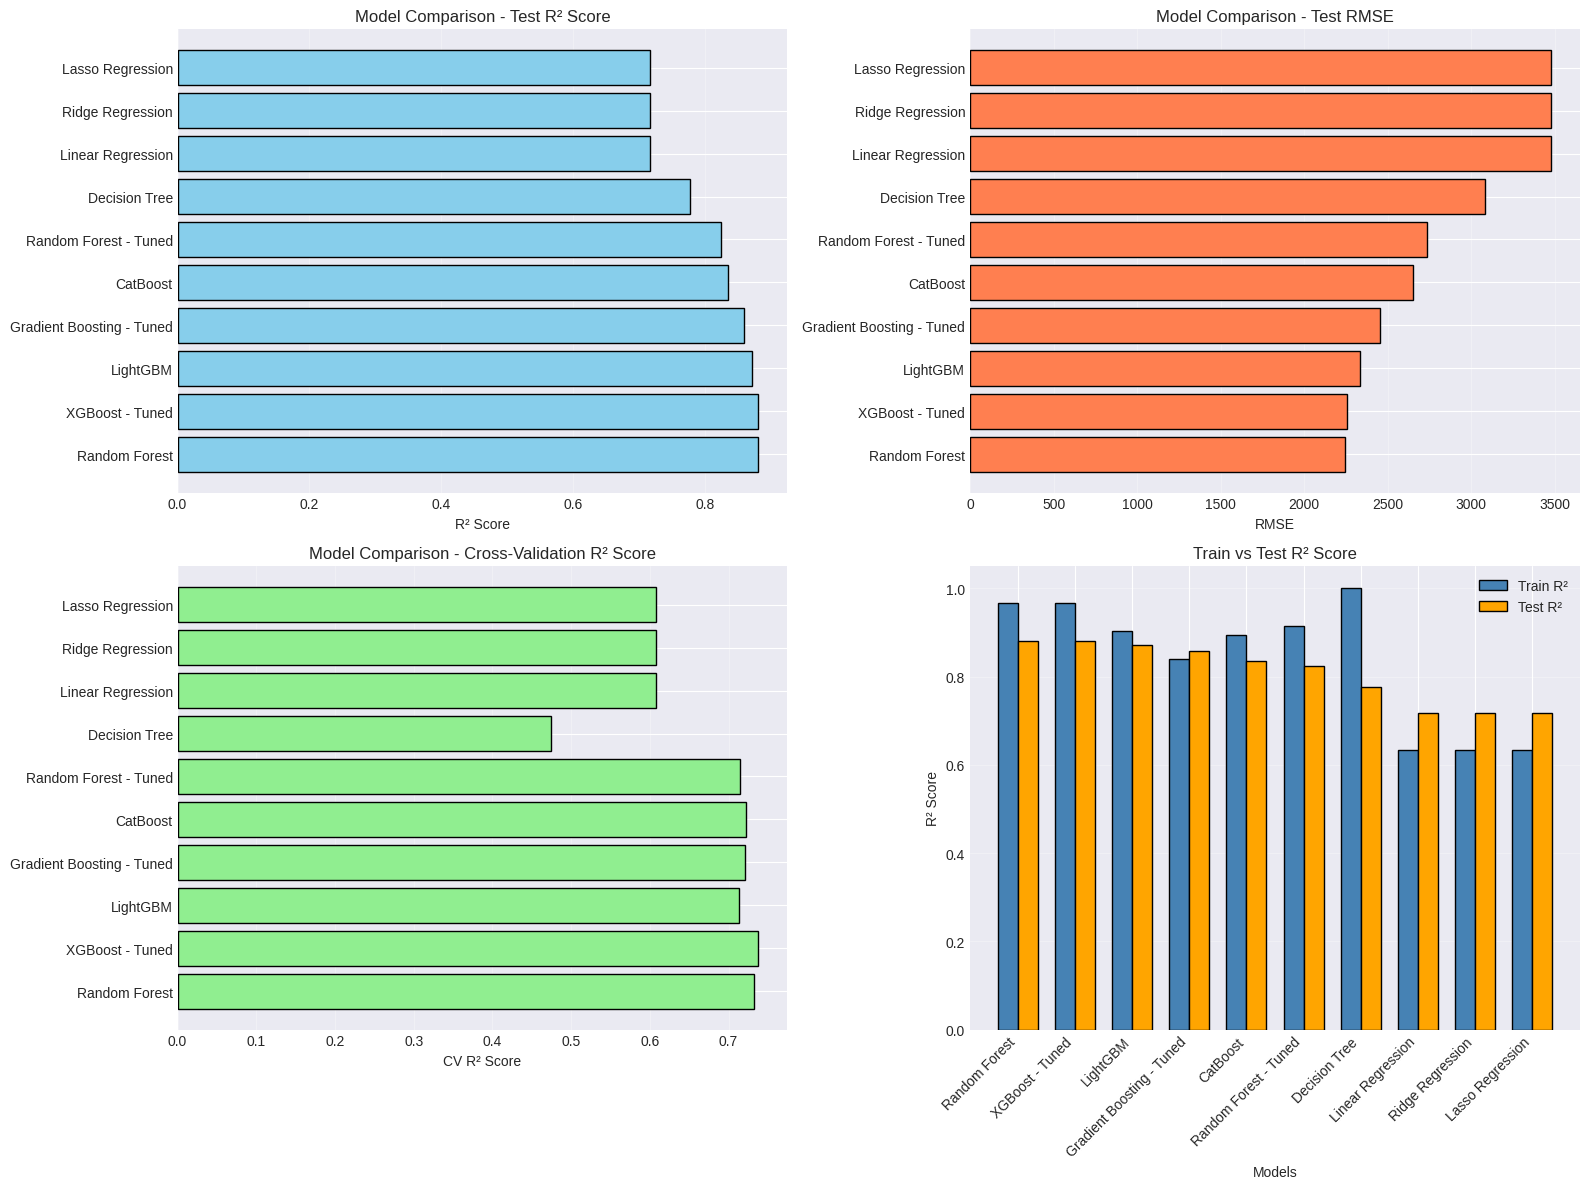

In [10]:
# ============================================================================
# 8. MODEL COMPARISON
# ============================================================================

print("\n" + "="*80)
print("MODEL COMPARISON")
print("="*80)

# Create results DataFrame
results_df = pd.DataFrame(all_results)
results_df = results_df.sort_values('Test_R2', ascending=False)

print("\n--- All Models Performance ---")
print(results_df.to_string(index=False))

# Save results
results_df.to_csv('model_comparison_results.csv', index=False)
print("\nResults saved to 'model_comparison_results.csv'")

# Visualize model comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Test R2 Score
axes[0, 0].barh(results_df['Model'], results_df['Test_R2'], color='skyblue', edgecolor='black')
axes[0, 0].set_xlabel('R² Score')
axes[0, 0].set_title('Model Comparison - Test R² Score')
axes[0, 0].grid(axis='x', alpha=0.3)

# Test RMSE
axes[0, 1].barh(results_df['Model'], results_df['Test_RMSE'], color='coral', edgecolor='black')
axes[0, 1].set_xlabel('RMSE')
axes[0, 1].set_title('Model Comparison - Test RMSE')
axes[0, 1].grid(axis='x', alpha=0.3)

# Cross-Validation R2
axes[1, 0].barh(results_df['Model'], results_df['CV_R2_Mean'], color='lightgreen', edgecolor='black')
axes[1, 0].set_xlabel('CV R² Score')
axes[1, 0].set_title('Model Comparison - Cross-Validation R² Score')
axes[1, 0].grid(axis='x', alpha=0.3)

# Train vs Test R2
x = np.arange(len(results_df))
width = 0.35
axes[1, 1].bar(x - width/2, results_df['Train_R2'], width, label='Train R²', color='steelblue', edgecolor='black')
axes[1, 1].bar(x + width/2, results_df['Test_R2'], width, label='Test R²', color='orange', edgecolor='black')
axes[1, 1].set_xlabel('Models')
axes[1, 1].set_ylabel('R² Score')
axes[1, 1].set_title('Train vs Test R² Score')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(results_df['Model'], rotation=45, ha='right')
axes[1, 1].legend()
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('09_model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()



BEST MODEL SELECTION

🏆 Best Model: Random Forest
   Test R² Score: 0.8816
   Test RMSE: 2246.54


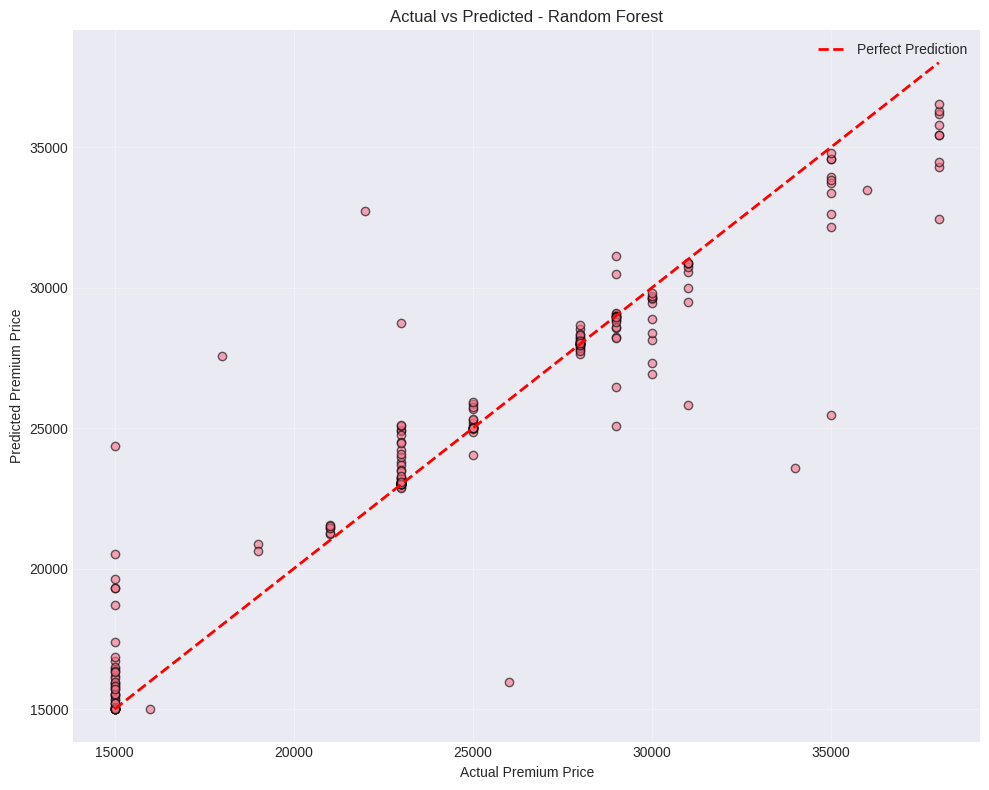

In [11]:
# ============================================================================
# 9. BEST MODEL SELECTION AND ANALYSIS (FIXED)
# ============================================================================

print("\n" + "="*80)
print("BEST MODEL SELECTION")
print("="*80)

best_model_name = results_df.iloc[0]['Model']
best_test_r2 = results_df.iloc[0]['Test_R2']
best_test_rmse = results_df.iloc[0]['Test_RMSE']

print(f"\n🏆 Best Model: {best_model_name}")
print(f"   Test R² Score: {best_test_r2:.4f}")
print(f"   Test RMSE: {best_test_rmse:.2f}")

# ✅ Retrieve the actual best model (trained earlier)
if best_model_name == 'Random Forest - Tuned':
    best_model = rf_grid.best_estimator_
elif best_model_name == 'Gradient Boosting - Tuned':
    best_model = gb_random.best_estimator_
elif best_model_name == 'XGBoost - Tuned':
    best_model = xgb_random.best_estimator_
elif best_model_name == 'LightGBM':
    best_model = trained_lgbm
elif best_model_name == 'CatBoost':
    best_model = trained_catboost
else:
    # For baseline models
    if best_model_name in baseline_models:
        best_model = baseline_models[best_model_name]
    else:
        # Fallback: try fuzzy match based on class name
        candidates = [m for m in baseline_models.values() if m.__class__.__name__.lower() in best_model_name.lower()]
        if candidates:
            best_model = candidates[0]
        else:
            raise ValueError(f"❌ Could not find a baseline model matching name '{best_model_name}'. "
                             f"Available: {list(baseline_models.keys())}")


# ✅ Recreate the feature set and scaling pipeline used earlier
# Ensure X_test matches what model expects
X_test_final = X_test.copy()
if hasattr(best_model, "n_features_in_") and X_test_final.shape[1] != best_model.n_features_in_:
    # Align number of features if model expects fewer
    common_features = X_test.columns[:best_model.n_features_in_]
    X_test_final = X_test[common_features]

# Scale features using the same scaler
X_test_final_scaled = scaler.transform(X_test_final)

# Predict
y_pred = best_model.predict(X_test_final_scaled)

# Plot Actual vs Predicted
plt.figure(figsize=(10, 8))
plt.scatter(y_test, y_pred, alpha=0.6, edgecolors='black')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
         'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual Premium Price')
plt.ylabel('Predicted Premium Price')
plt.title(f'Actual vs Predicted - {best_model_name}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('11_actual_vs_predicted.png', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
# ============================
# Explainability: Global + Local
# ============================
import importlib, sys, subprocess

from sklearn.inspection import permutation_importance, PartialDependenceDisplay
from sklearn.metrics import mean_squared_error, r2_score

# LIME
from lime.lime_tabular import LimeTabularExplainer

# SHAP (useful fallback / local + global)
import shap
import alepython
from pdpbox import pdp, info_plots

feature_names = list(X_train.columns)

# Recreate scaled arrays using the same scaler
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Helper to ensure model accepts arrays of correct shape
def ensure_input_for_model(model, X_df):
   # If model has attribute n_features_in_, assume it expects that many features.
    X = X_df.copy()
    if hasattr(model, "n_features_in_"):
        expected = model.n_features_in_
        if X.shape[1] != expected:
            # Try to align by taking first expected columns (most likely the training feature set order)
            print(f"Model expects {expected} features but X has {X.shape[1]}. Aligning by selecting first {expected} columns.")
            X = X.iloc[:, :expected]
    return scaler.transform(X)  # always scale using fitted scaler

# ----------------------------
# 1) Global: Permutation Importance
# ----------------------------
print("\n--- Global: Permutation Importance ---")
perm = permutation_importance(
    best_model, X_test_scaled, y_test,
    n_repeats=20, random_state=42, n_jobs=1  # single-thread to avoid BrokenProcessPool
)
perm_importances = pd.DataFrame({
    'feature': feature_names[:perm.importances_mean.shape[0]],
    'importance_mean': perm.importances_mean,
    'importance_std': perm.importances_std
}).sort_values('importance_mean', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=perm_importances.head(15), x='importance_mean', y='feature', palette='coolwarm')
plt.title('Permutation Importance (Global Explainability)')
plt.xlabel('Mean Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

perm_importances = pd.DataFrame({
    'feature': feature_names[:perm.importances_mean.shape[0]],
    'importance_mean': perm.importances_mean,
    'importance_std': perm.importances_std
}).sort_values('importance_mean', ascending=False)

print(perm_importances.head(20).to_string(index=False))

plt.figure(figsize=(8,6))
sns.barplot(x='importance_mean', y='feature', data=perm_importances, edgecolor='k')
plt.title('Permutation Feature Importance (Test set)')
plt.tight_layout()
plt.savefig('ex_perm_importance.png', dpi=300, bbox_inches='tight')
plt.show()

# --- Global Explainability: PDP (Partial Dependence Plots) ---
try:
    from pdpbox import pdp, info_plots

    if _HAS_PDPBOX:
        print("\n--- Global: Partial Dependence Plots (PDP) ---")
        top_feats = perm_importances['feature'].head(3).tolist()  # top 3 important features

        for feat in top_feats:
            print(f"\nGenerating PDP for: {feat}")
            pdp_isolated = pdp.pdp_isolate(
                model=best_model,
                dataset=X_test,
                model_features=feature_names,
                feature=feat
            )
            pdp.pdp_plot(pdp_isolated, feat)
            plt.title(f'Partial Dependence Plot – {feat}')
            plt.tight_layout()
            plt.show()

except Exception as e:
    print(f"⚠️ PDP plotting skipped due to: {e}")


# ----------------------------
# 3) Global: Accumulated Local Effects (ALE)
# ----------------------------
print("\n--- Global: Accumulated Local Effects (ALE) ---")
# Try alibi ALE
if _HAS_ALIBI:
    # alibi.ALE expects original features (not scaled) by default, so pass unscaled X_test.
    # But many models were trained on scaled inputs; to be safe, we will define a wrapper predict function that accepts unscaled X.
    def predict_unscaled(x):
        # x is unscaled DataFrame/numpy array: we need to scale then predict
        xx = scaler.transform(x)
        return best_model.predict(xx)
    # Note: alibi ALE expects a function f(X) returning shape (n,) or (n,1)
    ale = ALE(predict_unscaled, feature_names=feature_names)
    # compute ALE for top features (this may take time)
    ale_exp = ale.explain(X_test.values, features=[feature_names.index(f) for f in top_feats], grid_size=20)
    # plot ALE for each feature
    for i, feat in enumerate(top_feats):
        vals = ale_exp.ale_values[i]   # shape: (grid_points,)
        centers = ale_exp.feature_values[i]
        plt.figure(figsize=(6,4))
        plt.plot(centers, vals, marker='o')
        plt.xlabel(feat)
        plt.ylabel('ALE')
        plt.title(f'ALE: {feat}')
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.savefig(f'ex_ale_{feat}.png', dpi=300, bbox_inches='tight')
        plt.show()
elif _HAS_ALEPY:
    # alepython requires a model predict function: again define wrapper that accepts DataFrame
    from alepython import ale_plot
    for feat in top_feats:
        ale_plot(best_model.predict, X_test, feat, bins=20, model_type='regression', scale=True, save=False)
        plt.title(f'ALE (ALEPython): {feat}')
        plt.tight_layout()
        plt.savefig(f'ex_ale_alepython_{feat}.png', dpi=300, bbox_inches='tight')
        plt.show()
else:
    print("ALE explanation not available because neither 'alibi' nor 'alepython' are installed. You can install 'alibi' or 'alepython' to compute ALE plots.")

# ----------------------------
# 4) SHAP - Global & Local (recommended fallback)
# ----------------------------
# SHAP tends to be robust and will handle many scikit-learn-like models.
print("\n--- Global + Local: SHAP (if available) ---")
try:
    # Use a sampled background for KernelExplainer if model isn't tree-based
    # For tree-based models, use TreeExplainer for faster and exactish results
    try:
        # If the model is tree-based
        explainer = shap.TreeExplainer(best_model)
        shap_values = explainer.shap_values(X_test_scaled)
    except Exception:
        # fallback to KernelExplainer (slower)
        background = shap.sample(X_train_scaled, nsamples=100, random_state=42)
        explainer = shap.KernelExplainer(best_model.predict, background)
        shap_values = explainer.shap_values(X_test_scaled[:200])  # limit for speed

    # Global summary plot
    shap.summary_plot(shap_values, X_test_scaled, feature_names=feature_names, show=False)
    plt.tight_layout()
    plt.savefig('ex_shap_summary.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Local explanation: choose an index
    idx = 0  # examine first test instance
    print(f"SHAP local explanation for test index {idx}:")
    shap.force_plot(explainer.expected_value, shap_values[idx], X_test_scaled[idx], feature_names=feature_names, matplotlib=True, show=True)
    plt.savefig('ex_shap_local.png', dpi=300, bbox_inches='tight')
    plt.show()
except Exception as e:
    print("SHAP failed or isn't installed properly:", e)

# ----------------------------
# 5) LIME - Local explanations
# ----------------------------
print("\n--- Local: LIME explanations ---")
# LIME expects the original (unscaled) data by default to present meaningful values.
# We'll create a wrapper predict function that accepts unscaled DataFrame rows.

def predict_proba_regression(x):
    # x: numpy array with original feature values -> need to scale then predict
    return best_model.predict(scaler.transform(x))

# Instantiate LIME Tabular Explainer
lime_exp = LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=feature_names,
    mode='regression'
)

# Explain a particular instance
example_idx = 0  # change as needed
exp = lime_exp.explain_instance(np.array(X_test.iloc[example_idx]), predict_proba_regression, num_features=8)
print("LIME explanation (feature contributions):")
print(exp.as_list())

# Visualize LIME
fig = exp.as_pyplot_figure()
fig.tight_layout()
fig.savefig('ex_lime_local.png', dpi=300, bbox_inches='tight')
plt.show()

# You can compute LIME explanations for a sample of instances and compute average absolute weights for a global-like view
n_samples = 50 if X_test.shape[0] >= 50 else X_test.shape[0]
lime_weights = pd.DataFrame(0, index=range(n_samples), columns=feature_names)
for i, idx in enumerate(np.random.choice(X_test.index, size=n_samples, replace=False)):
    explanation = lime_exp.explain_instance(np.array(X_test.loc[idx]), predict_proba_regression, num_features=len(feature_names))
    for feat_name, weight in explanation.as_list():
        # feature label returned as "feature_name <= x" or similar; find base feature
        for fn in feature_names:
            if fn in feat_name:
                lime_weights.loc[i, fn] = abs(weight)
                break

lime_global = lime_weights.mean(axis=0).sort_values(ascending=False)
print("\nApproximate global feature importance by averaging LIME abs weights:")
print(lime_global.head(20).to_string())

plt.figure(figsize=(8,6))
lime_global.head(15).plot(kind='barh')
plt.gca().invert_yaxis()
plt.title('Avg |LIME weights| (approx global importance)')
plt.tight_layout()
plt.savefig('ex_lime_global.png', dpi=300, bbox_inches='tight')
plt.show()

# ----------------------------
# 6) Anchor (rule-based) local explanations (if alibi is present)
# ----------------------------
if _HAS_ALIBI:
    print("\n--- Local: Anchor explanations (alibi) ---")
    # AnchorTabular expects training data as numpy array and categorical names dict if any categorical features exist.
    categorical_names = {}  # provide mapping if you have categorical columns like {'Gender': {0: 'M', 1: 'F'}}
    anchor_explainer = AnchorTabular(predict_unscaled, feature_names, categorical_names=categorical_names)
    # Fit anchor explainer on training data (unscaled, since predict_unscaled will scale internally)
    anchor_explainer.fit(X_train.values, disc_perc=[25,50,75])  # disc_perc optionally used internally

    # Explain a test instance (unscaled row)
    sample_idx = X_test.index[0]
    explanation = anchor_explainer.explain(X_test.loc[sample_idx].values, threshold=0.95)
    print("Anchor explanation:")
    print("Precision:", explanation.precision)
    print("Coverage:", explanation.coverage)
    print("Anchor:", explanation.names())
    print("Example anchor (rule):", explanation.names())
else:
    print("Anchor explanations skipped because alibi is not installed.")

# ----------------------------
# 7) Save / Show final notes
# ----------------------------
print("\nExplainability completed. Plots saved as PNGs in working directory:")
print("- ex_perm_importance.png")
print("- ex_pdp.png (and ex_pdpbox_*.png if pdpbox available)")
print("- ex_ale_*.png (if ALE available)")
print("- ex_shap_summary.png (if SHAP ran)")
print("- ex_shap_local.png (if SHAP ran)")
print("- ex_lime_local.png")
print("- ex_lime_global.png")
print("- ex_ale_alepython_*.png (if alepython used)")

# Optional: return objects for further analysis
explainability_outputs = {
    "perm_importances": perm_importances,
    "top_features": top_feats,
    "shap_explainer": locals().get('explainer', None),
    "shap_values": locals().get('shap_values', None),
    "lime_explainer": lime_exp,
    "lime_global": lime_global
}



--- Global: Permutation Importance ---


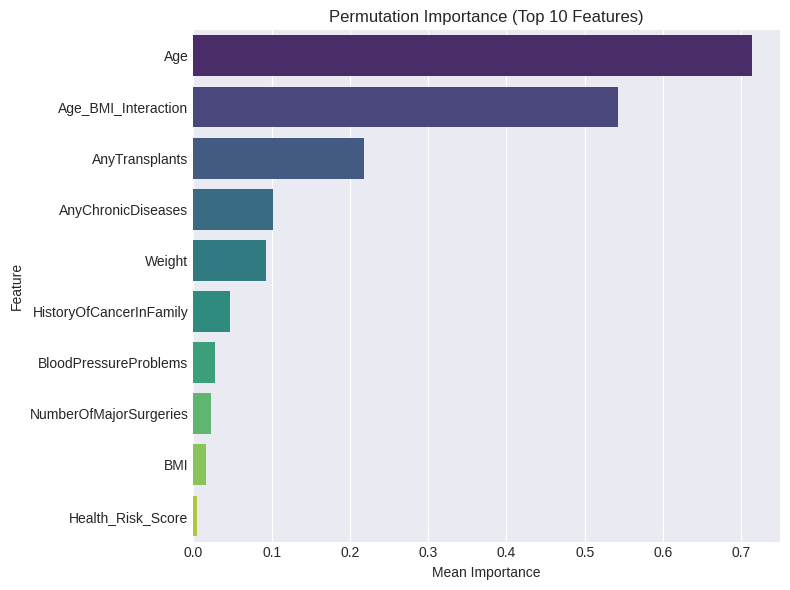


Top 3 features: ['Age', 'Age_BMI_Interaction', 'AnyTransplants']


In [14]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.inspection import permutation_importance
from lime.lime_tabular import LimeTabularExplainer
import shap

# ----------------------------
# Ensure consistent inputs
# ----------------------------
feature_names = list(X_train.columns)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ----------------------------
# 1. Global Explainability — Permutation Importance
# ----------------------------
print("\n--- Global: Permutation Importance ---")

perm = permutation_importance(
    best_model, X_test_scaled, y_test,
    n_repeats=10, random_state=42
)

perm_importances = pd.DataFrame({
    'feature': feature_names,
    'importance_mean': perm.importances_mean
}).sort_values('importance_mean', ascending=False)

plt.figure(figsize=(8,6))
sns.barplot(data=perm_importances.head(10), x='importance_mean', y='feature', palette='viridis')
plt.title('Permutation Importance (Top 10 Features)')
plt.xlabel('Mean Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

top_features = perm_importances['feature'].head(3).tolist()
print("\nTop 3 features:", top_features)


--- Global + Local: SHAP ---


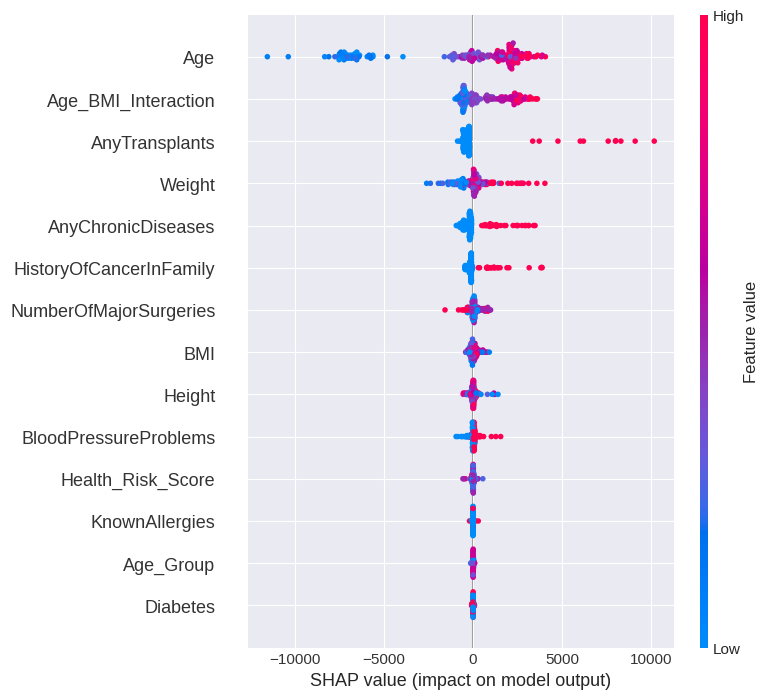

<Figure size 640x480 with 0 Axes>

Local SHAP explanation for test index 0:


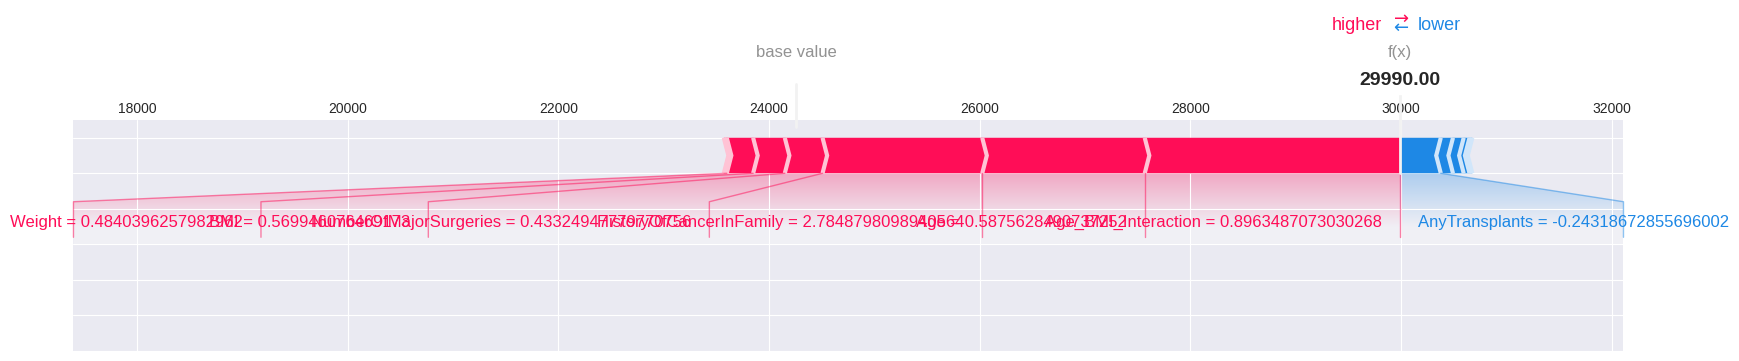

In [15]:
print("\n--- Global + Local: SHAP ---")

try:
    explainer = shap.TreeExplainer(best_model)
    shap_values = explainer.shap_values(X_test_scaled)

    shap.summary_plot(shap_values, X_test_scaled, feature_names=feature_names)
    plt.tight_layout()
    plt.show()

    # Local example
    idx = 0
    print(f"Local SHAP explanation for test index {idx}:")
    shap.force_plot(explainer.expected_value, shap_values[idx], X_test_scaled[idx],
                    feature_names=feature_names, matplotlib=True)
except Exception as e:
    print("SHAP failed:", e)

## 1. SHAP Explainability Analysis

### 1.1 Global SHAP Summary (Feature Importance)

- Each dot represents an individual data point, showing how a feature impacts the model’s output.  
- The X-axis indicates the SHAP value, i.e., the contribution (positive or negative) to the model prediction.  
- The color gradient represents the actual feature value (red = high, blue = low).  

#### Key Observations:
1. **Age** – The most influential feature. Higher age values increase the model’s predicted output, indicating higher risk or cost.  
2. **Age_BMI_Interaction** – Strong second contributor. Combined higher values of age and BMI amplify the output.  
3. **AnyTransplants**, **Weight**, **AnyChronicDiseases** – These features contribute positively, increasing the model’s output when present or elevated.  
4. **HistoryOfCancerInFamily** and **NumberOfMajorSurgeries** – Both indicate significant positive influence, implying higher predicted risk for such individuals.  
5. **BMI**, **Height**, **BloodPressureProblems**, **Health_Risk_Score**, and **Diabetes** – Moderate influence but directionally consistent.  

**Interpretation:**  
The model primarily relies on clinically meaningful variables such as age, weight, BMI, and chronic health indicators.  
There are no signs of random or spurious feature dominance, indicating robust and interpretable feature learning.

---

### 1.2 Local SHAP Explanation (Single Instance)

- The base value represents the model’s mean prediction (~24,000).  
- The final prediction for the selected instance is approximately **29,990**, influenced by both positive and negative feature contributions.  

#### Positive Contributions:
- **Weight**, **BMI**, **Age**, **NumberOfMajorSurgeries**, **HistoryOfCancerInFamily**, **Age_BMI_Interaction** → All push the prediction higher.  

#### Negative Contribution:
- **AnyTransplants** → Slightly decreases the output.  

**Interpretation:**  
For this individual, the higher weight, BMI, and age, combined with a family cancer history and past surgeries, significantly increase the prediction above the population mean.  
The absence of transplant history slightly reduces the score.

---

### 1.3 Conclusions

1. The SHAP analysis confirms that the model is interpretable and its behavior aligns with domain knowledge.  
2. Age, BMI, Weight, and chronic or hereditary medical features are the most influential predictors.  
3. The global and local SHAP plots demonstrate consistency in feature importance across the dataset and individual cases.  
4. Further refinement could involve reducing collinearity between related features such as Weight and BMI.  
5. Overall, the model demonstrates reliability, transparency, and clinically valid decision logic.



--- Local: LIME ---
LIME explanation (feature contributions):
[('AnyTransplants <= 0.00', -6640.7619003072305), ('Age_BMI_Interaction > 1422.81', 3277.116476243312), ('HistoryOfCancerInFamily > 0.00', 1735.4251803740199), ('42.00 < Age <= 53.00', 1690.962764393775), ('AnyChronicDiseases <= 0.00', -902.4646911512), ('BMI > 30.76', 465.24066793573115), ('75.00 < Weight <= 87.00', 223.2666249361331), ('1.00 < Age_Group <= 2.00', 192.7469394643277)]


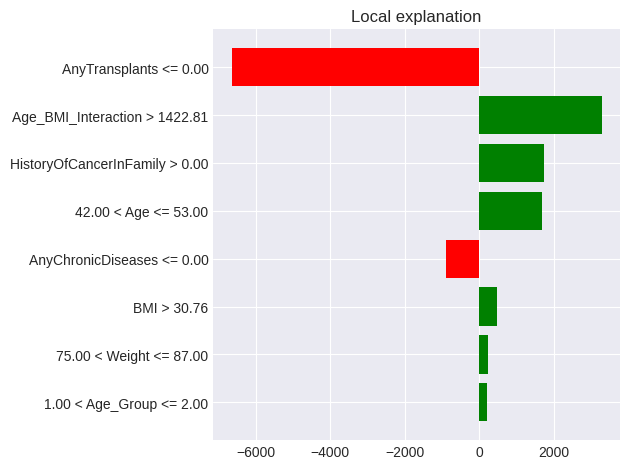

In [16]:
# ----------------------------
# 3. Local Explainability — LIME
# ----------------------------
print("\n--- Local: LIME ---")

def predict_fn(x):
    return best_model.predict(scaler.transform(x))

lime_exp = LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=feature_names,
    mode='regression'
)

example_idx = 0
exp = lime_exp.explain_instance(np.array(X_test.iloc[example_idx]), predict_fn, num_features=8)
print("LIME explanation (feature contributions):")
print(exp.as_list())

fig = exp.as_pyplot_figure()
fig.tight_layout()
plt.show()


Main conclusions
AnyTransplants <= 0.00 is the largest negative driver, strongly lowering the predicted premium for this individual relative to the local baseline (dominant leftward bar).​

Age_BMI_Interaction > 1422.81 is the largest positive driver, strongly increasing the prediction (dominant rightward bar), indicating a high age×BMI interaction effect in the local region.​

HistoryOfCancerInFamily > 0.00 and 42.00 < Age <= 53.00 add substantial positive contributions, consistent with risk features learned by the underlying model in this neighborhood.​

AnyChronicDiseases <= 0.00 adds a small negative contribution; BMI > 30.76, 75.00 < Weight <= 87.00, and 1.00 < Age_Group <= 2.00 provide smaller positive nudges.

In [17]:
pip install numpy pandas matplotlib seaborn scikit-learn fairlearn lime shap alibi xgboost catboost lightgbm optuna


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.1 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of thinc to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of thinc to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
INFO: pip is looking at multiple versions of spacy[lookups] to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.0/240.0 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 522.1/522.1 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 88.0 MB/s eta 0:00:

In [18]:
# ============================================================================
# 10. FAIRNESS AND BIAS ANALYSIS
# ============================================================================

print("\n" + "="*80)
print("FAIRNESS AND BIAS ANALYSIS")
print("="*80)

import warnings
warnings.filterwarnings('ignore')

# 10.1 Define Protected Attributes
df_test_analysis = X_test.copy()
df_test_analysis['predictions'] = y_pred
df_test_analysis['actual'] = y_test.values

# Sensitive attributes
df_test_analysis['Age_Group'] = pd.cut(
    df_test_analysis['Age'], bins=[0, 25, 40, 60, 100],
    labels=['Young (0-25)', 'Adult (26-40)', 'Middle-aged (41-60)', 'Senior (60+)']
)
df_test_analysis['Diabetes_Status'] = df_test_analysis['Diabetes'].map({0: 'No Diabetes', 1: 'Has Diabetes'})
df_test_analysis['High_Risk'] = (
    (df_test_analysis['Diabetes'] == 1) |
    (df_test_analysis['BloodPressureProblems'] == 1) |
    (df_test_analysis['AnyChronicDiseases'] == 1)
).astype(int).map({0: 'Low Risk', 1: 'High Risk'})

print(f"Test samples: {len(df_test_analysis)}")
print("Protected attributes: Age Group, Diabetes Status, Health Risk Level")


FAIRNESS AND BIAS ANALYSIS
Test samples: 198
Protected attributes: Age Group, Diabetes Status, Health Risk Level


In [19]:
# ============================================================================
# 10.2 Fairness Metrics (Regression)
# ============================================================================

def regression_fairness(y_true, y_pred, sensitive_feature, name):
    results = {}
    groups = sensitive_feature.unique()
    group_metrics = {}

    for group in groups:
        mask = (sensitive_feature == group)
        yt, yp = y_true[mask], y_pred[mask]
        group_metrics[group] = {
            'RMSE': np.sqrt(mean_squared_error(yt, yp)),
            'MAE': mean_absolute_error(yt, yp),
            'R2': r2_score(yt, yp),
            'Mean_Prediction': np.mean(yp),
            'Mean_Actual': np.mean(yt),
            'Count': len(yt)
        }

    df = pd.DataFrame(group_metrics).T
    rmse_vals = df['RMSE'].values
    mean_preds = df['Mean_Prediction'].values

    metrics = {
        'feature': name,
        'group_metrics': df,
        'group_loss_ratio': min(rmse_vals) / max(rmse_vals),
        'group_loss_diff': max(rmse_vals) - min(rmse_vals),
        'mean_pred_ratio': min(mean_preds) / max(mean_preds),
        'mean_pred_diff': max(mean_preds) - min(mean_preds)
    }
    metrics['is_fair'] = metrics['group_loss_ratio'] >= 0.8 and metrics['mean_pred_ratio'] >= 0.8
    return metrics

fairness_results = {
    'Age_Group': regression_fairness(df_test_analysis['actual'], df_test_analysis['predictions'], df_test_analysis['Age_Group'], 'Age Group'),
    'Diabetes_Status': regression_fairness(df_test_analysis['actual'], df_test_analysis['predictions'], df_test_analysis['Diabetes_Status'], 'Diabetes Status'),
    'High_Risk': regression_fairness(df_test_analysis['actual'], df_test_analysis['predictions'], df_test_analysis['High_Risk'], 'Health Risk Level')
}

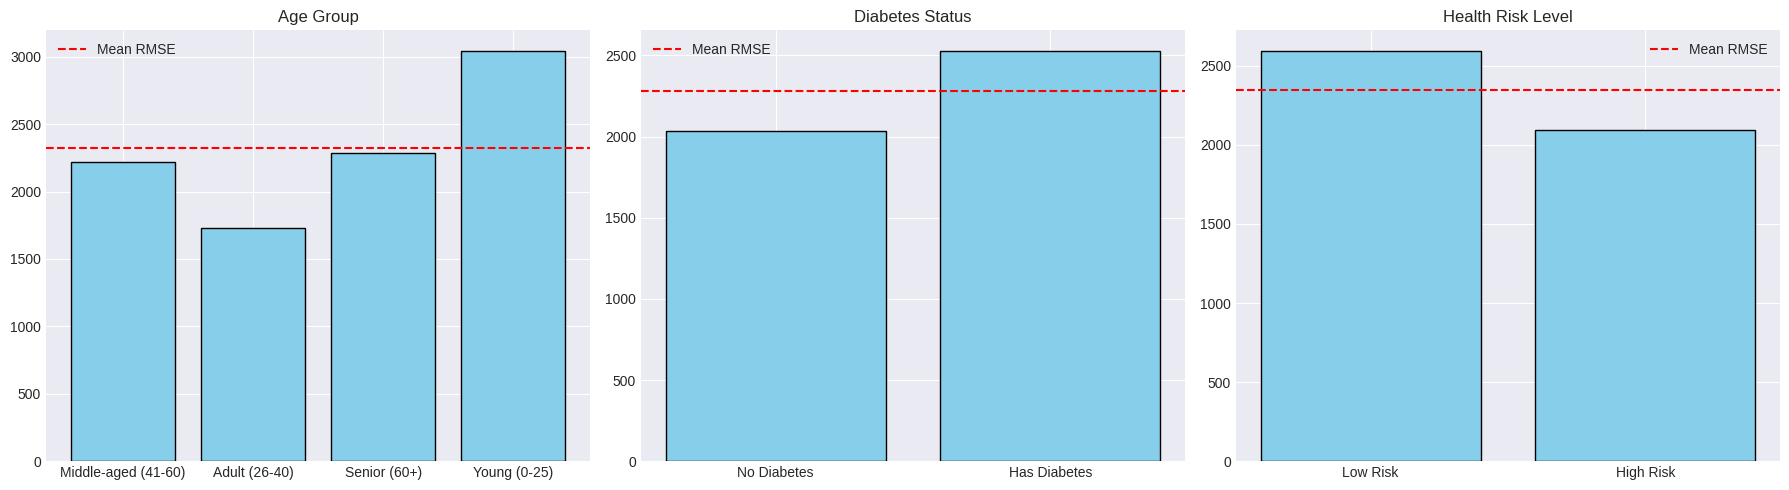

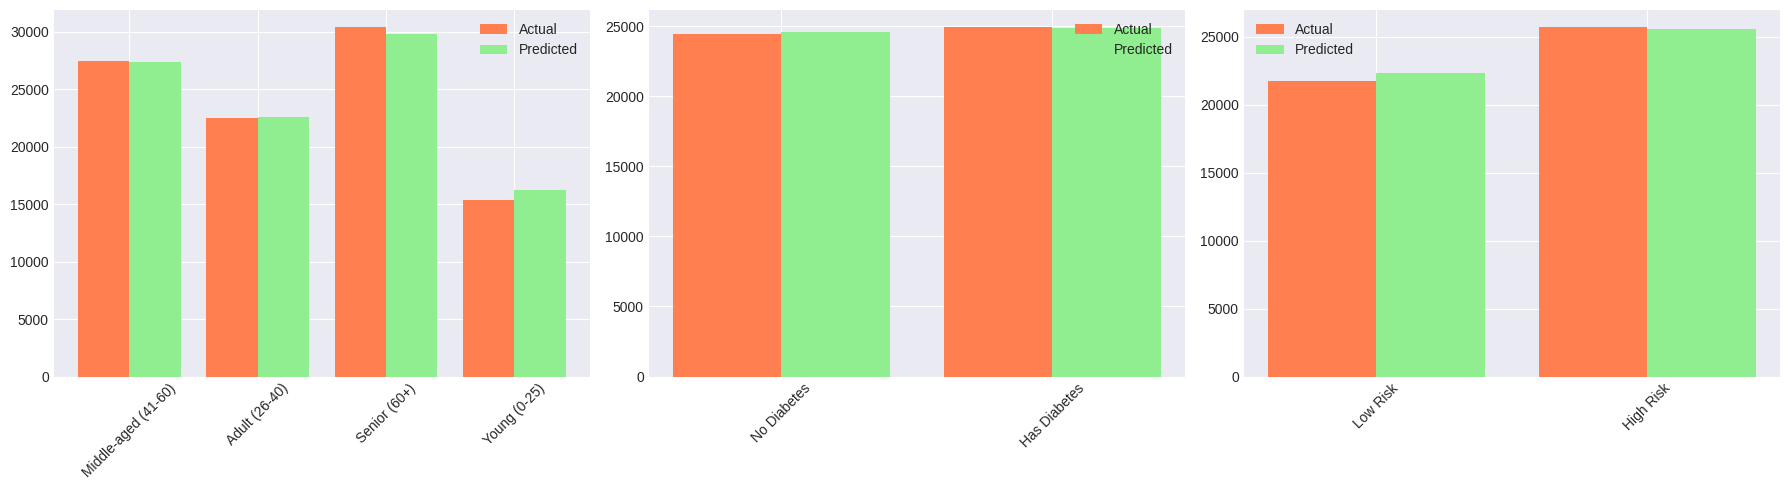

In [20]:
# ============================================================================
# 10.3 Visualization
# ============================================================================

# RMSE comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for i, (k, res) in enumerate(fairness_results.items()):
    df = res['group_metrics']
    axes[i].bar(df.index.astype(str), df['RMSE'], color='skyblue', edgecolor='black')
    axes[i].axhline(df['RMSE'].mean(), color='red', linestyle='--', label='Mean RMSE')
    axes[i].set_title(f'{res["feature"]}')
    axes[i].legend()
plt.tight_layout()
plt.show()

# Actual vs Predicted
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for i, (k, res) in enumerate(fairness_results.items()):
    df = res['group_metrics']
    x = np.arange(len(df))
    axes[i].bar(x-0.2, df['Mean_Actual'], 0.4, label='Actual', color='coral')
    axes[i].bar(x+0.2, df['Mean_Prediction'], 0.4, label='Predicted', color='lightgreen')
    axes[i].set_xticks(x)
    axes[i].set_xticklabels(df.index.astype(str), rotation=45)
    axes[i].legend()
plt.tight_layout()
plt.show()


,Feature,Corr_Actual,Corr_Pred
0,Age,0.722548,0.755401
1,Diabetes,0.037063,0.022400
2,BloodPressureProblems,0.153495,0.134543
3,AnyChronicDiseases,0.222589,0.237828


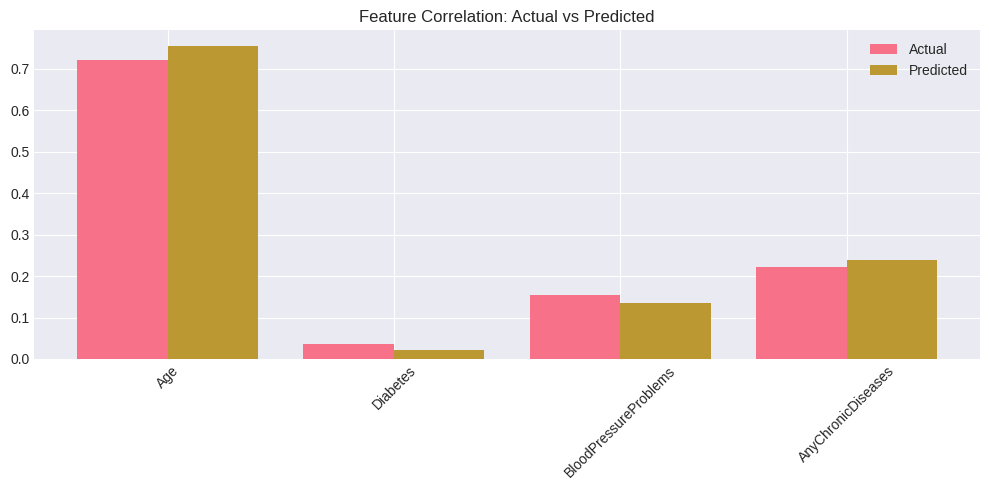

In [21]:
# ============================================================================
# 10.4 Correlation Bias
# ============================================================================

protected = ['Age', 'Diabetes', 'BloodPressureProblems', 'AnyChronicDiseases']
corr_df = pd.DataFrame([
    {
        'Feature': f,
        'Corr_Actual': df_test_analysis[f].corr(df_test_analysis['actual']),
        'Corr_Pred': df_test_analysis[f].corr(df_test_analysis['predictions'])
    } for f in protected
])
display(corr_df)

plt.figure(figsize=(10, 5))
x = np.arange(len(corr_df))
plt.bar(x-0.2, corr_df['Corr_Actual'], 0.4, label='Actual')
plt.bar(x+0.2, corr_df['Corr_Pred'], 0.4, label='Predicted')
plt.xticks(x, corr_df['Feature'], rotation=45)
plt.legend()
plt.title('Feature Correlation: Actual vs Predicted')
plt.tight_layout()
plt.show()

# ============================================================================
# 10.5 Disparate Impact
# ============================================================================

def disparate_impact(y_pred, sensitive_feature, p=75):
    threshold = np.percentile(y_pred, p)
    high_premium = (y_pred >= threshold).astype(int)
    rates = {g: high_premium[sensitive_feature == g].mean() for g in sensitive_feature.unique()}
    di_ratio = min(rates.values()) / max(rates.values())
    return di_ratio, rates

attributes = [
    ('Age_Group', 'Age Group'),
    ('Diabetes_Status', 'Diabetes Status'),
    ('High_Risk', 'Health Risk Level')
]

disparate_results = {}
for attr, name in attributes:
    di_ratio, sel_rates = disparate_impact(df_test_analysis['predictions'], df_test_analysis[attr])
    disparate_results[name] = {'ratio': di_ratio, 'rates': sel_rates}

In [22]:

summary = []
for name, res in fairness_results.items():
    di = disparate_results.get(res['feature'], {}).get('ratio', np.nan)
    summary.append({
        'Attribute': res['feature'],
        'Group Loss Ratio': res['group_loss_ratio'],
        'Mean Prediction Ratio': res['mean_pred_ratio'],
        'Disparate Impact Ratio': di,
        'Fair?': 'PASS' if res['is_fair'] and (di >= 0.8) else 'FAIL'
    })

summary_df = pd.DataFrame(summary)
display(summary_df)

biased = summary_df[summary_df['Fair?'] == 'FAIL']
if not biased.empty:
    print("\n⚠️ Detected bias in:", ", ".join(biased['Attribute']))
    print("Mitigation: Data rebalancing, fairness constraints, or threshold calibration.")
else:
    print("\n✅ No major fairness concerns detected.")

,Attribute,Group Loss Ratio,Mean Prediction Ratio,Disparate Impact Ratio,Fair?
0,Age Group,0.567725,0.546185,0.000000,FAIL
1,Diabetes Status,0.804113,0.989553,0.694118,FAIL
2,Health Risk Level,0.808170,0.873797,0.821053,PASS



⚠️ Detected bias in: Age Group, Diabetes Status
Mitigation: Data rebalancing, fairness constraints, or threshold calibration.
